# Library

In [1]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
# Others
import shutil
import random

# Load dataset

In [4]:
# Download dataset
od.download('https://www.kaggle.com/datasets/ahmadhabibhasanzein/cherry-leaves')

Skipping, found downloaded files in "./cherry-leaves" (use force=True to force download)


In [5]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/cherry-leaves/cherry-leaves/train",
    label_mode="categorical",
    class_names=['healthy','powdery_mildew'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/cherry-leaves/cherry-leaves/test",
    label_mode="categorical",
    class_names=['healthy','powdery_mildew'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 4205 files belonging to 2 classes.
==========================Validation Data====================
Found 1574 files belonging to 2 classes.


In [6]:
# All images will be rescaled by 1./255.and augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("/content/cherry-leaves/cherry-leaves/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("/content/cherry-leaves/cherry-leaves/test",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 4205 images belonging to 2 classes.
Found 1574 images belonging to 2 classes.


# List Resource

In [7]:
# Check GPU
!nvidia-smi

Mon May 29 05:13:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    25W /  70W |    389MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

# Modelling With Augmentation

## Xception Model 1

In [10]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Cherry_Xception_model1_Based_Augmented.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [11]:
# Define DIY Model
Xception_model = tf.keras.models.Sequential([
    # Xception Layer
    Xception(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
Xception_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
Xception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21,386,538
Trainable params: 21,332,010
Non-trainable params: 54,528
_______________________________________

In [12]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_Xception_model_1 = Xception_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
211/211 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.9769
Epoch 1: val_accuracy improved from -inf to 0.99746, saving model to Cherry_Xception_model1_Based_Augmented.h5
211/211 [==============================] - 138s 410ms/step - loss: 0.1109 - accuracy: 0.9769 - val_loss: 0.0089 - val_accuracy: 0.9975 - lr: 0.0010
Epoch 2/100
211/211 [==============================] - ETA: 0s - loss: 0.0298 - accuracy: 0.9931
Epoch 2: val_accuracy did not improve from 0.99746
211/211 [==============================] - 78s 370ms/step - loss: 0.0298 - accuracy: 0.9931 - val_loss: 1.3484 - val_accuracy: 0.8513 - lr: 0.0010
Epoch 3/100
211/211 [==============================] - ETA: 0s - loss: 0.0281 - accuracy: 0.9931
Epoch 3: val_accuracy did not improve from 0.99746
211/211 [==============================] - 78s 368ms/step - loss: 0.0281 - accuracy: 0.9931 - val_loss: 0.4645 - val_accuracy: 0.9892 - lr: 0.0010
Epoch 4/100
211/211 [==============================] -

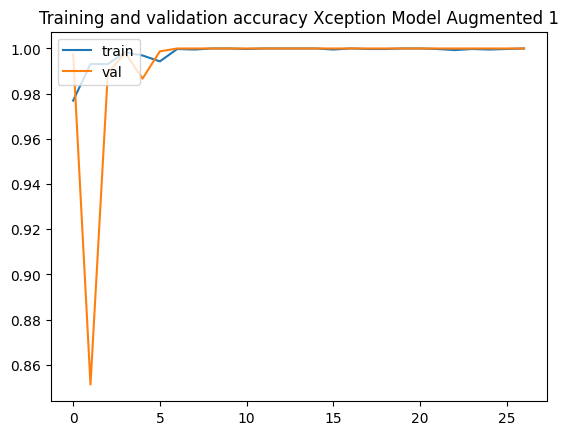

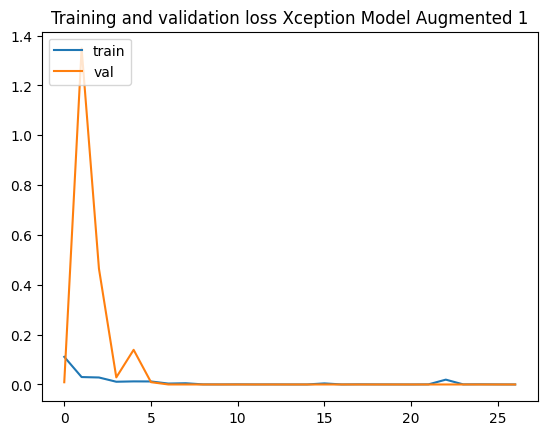

In [13]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_Xception_model_1.history['accuracy' ]
val_acc  = history_Xception_model_1.history['val_accuracy' ]
loss     = history_Xception_model_1.history['loss' ]
val_loss = history_Xception_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy Xception Model Augmented 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss Xception Model Augmented 1')
plt.legend(['train', 'val'], loc='upper left')

## Xception Model 2

In [14]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Cherry_Xception_model2_Based_Augmented.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [15]:
# Define DIY Model
Xception_model_2 = tf.keras.models.Sequential([
    # Xception Layer
    Xception(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
Xception_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
Xception_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21,386,538
Trainable params: 21,332,010
Non-trainable params: 54,528
_____________________________________

In [16]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_Xception_model_2 = Xception_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
211/211 [==============================] - ETA: 0s - loss: 0.0530 - accuracy: 0.9862
Epoch 1: val_accuracy improved from -inf to 0.90343, saving model to Cherry_Xception_model2_Based_Augmented.h5
211/211 [==============================] - 111s 399ms/step - loss: 0.0530 - accuracy: 0.9862 - val_loss: 5.7752 - val_accuracy: 0.9034 - lr: 0.0010
Epoch 2/100
211/211 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9964
Epoch 2: val_accuracy improved from 0.90343 to 0.99936, saving model to Cherry_Xception_model2_Based_Augmented.h5
211/211 [==============================] - 81s 385ms/step - loss: 0.0198 - accuracy: 0.9964 - val_loss: 0.0045 - val_accuracy: 0.9994 - lr: 0.0010
Epoch 3/100
211/211 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9993
Epoch 3: val_accuracy improved from 0.99936 to 1.00000, saving model to Cherry_Xception_model2_Based_Augmented.h5
211/211 [==============================] - 90s 424ms/step - loss: 0.0017 - 

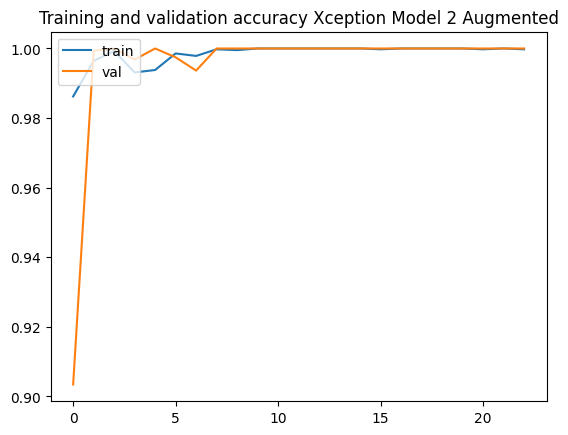

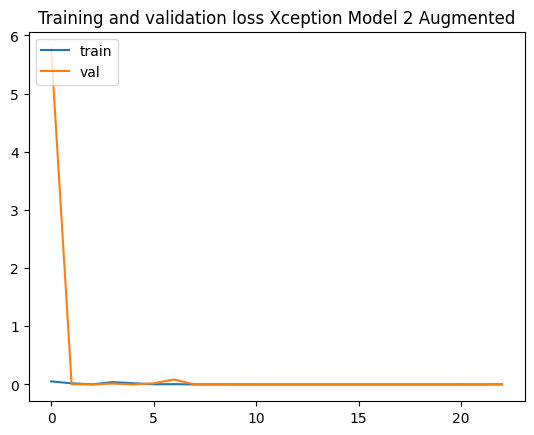

In [18]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_Xception_model_2.history['accuracy' ]
val_acc  = history_Xception_model_2.history['val_accuracy' ]
loss     = history_Xception_model_2.history['loss' ]
val_loss = history_Xception_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy Xception Model 2 Augmented')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss Xception Model 2 Augmented')
plt.legend(['train', 'val'], loc='upper left')